In [1]:
pip install xgboost

Defaulting to user installation because normal site-packages is not writeable
Note: you may need to restart the kernel to use updated packages.


🚀 НАЧИНАЕМ ПОДГОТОВКУ ДАННЫХ...
🔗 ОБЪЕДИНЕНИЕ И ОЧИСТКА ДАННЫХ...
📥 ЗАГРУЗКА ВСЕХ ДАННЫХ...
✅ Demographics: (89999, 8)
✅ Loan details: (89999, 10)
✅ Application metadata: (89999, 14)
✅ Geographic data: (89999, 8)
✅ Financial ratios: (89999, 16)
✅ Credit history: (89999, 12)
📊 Объединенный датасет: (89999, 68)
✅ Очищенные данные: (89999, 68)
🎯 Уровень дефолта: 0.051
🎯 ВЫБОР НУЖНЫХ СТОЛБЦОВ...
✅ Найдено признаков: 26
📊 Кредитные: 8
📊 Финансовые: 12
📊 Географические: 5
📊 Итоговый датасет для моделирования: (89999, 26)
🎯 Уровень дефолта: 0.0510

🚀 ЗАПУСК МОДЕЛИРОВАНИЯ...
🛠️ ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ...
✅ Данные подготовлены: X (89999, 25), y (89999,)
🎯 Баланс классов: default
0    0.948955
1    0.051045
Name: proportion, dtype: float64
📊 Используемые признаки: ['credit_score', 'num_credit_accounts', 'oldest_credit_line_age', 'num_delinquencies_2yrs', 'num_inquiries_6mo', 'num_public_records', 'num_collections', 'account_diversity_index', 'monthly_income', 'existing_monthly_debt',

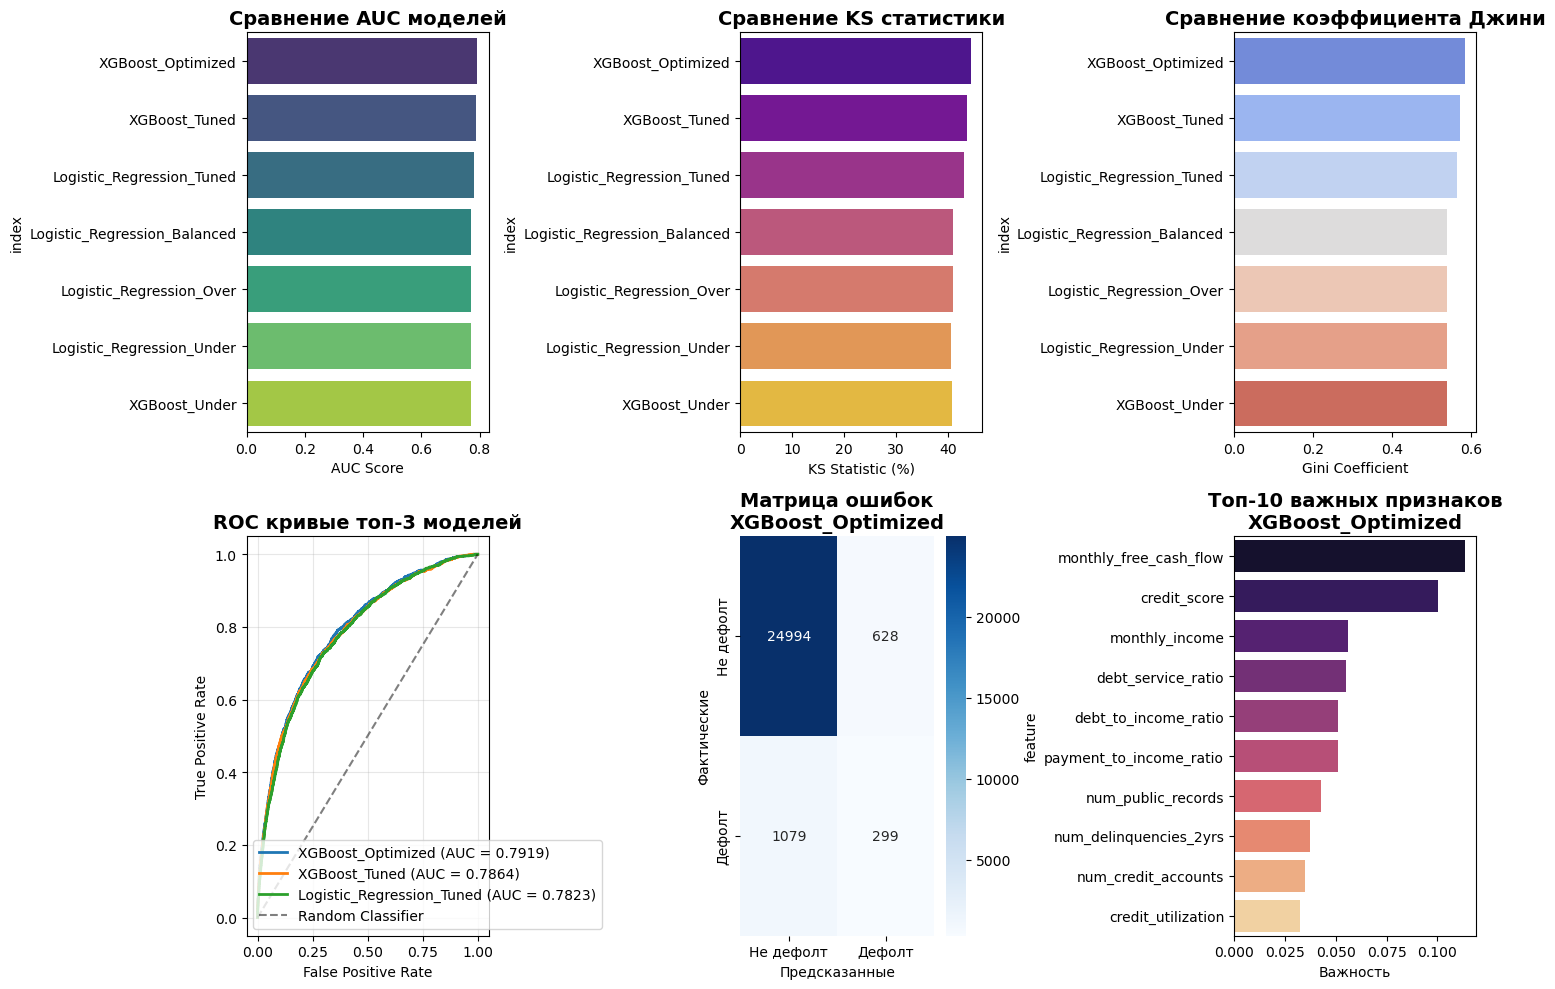


🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: XGBoost_Optimized
📋 ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

   Не дефолт       0.96      0.98      0.97     25622
      Дефолт       0.32      0.22      0.26      1378

    accuracy                           0.94     27000
   macro avg       0.64      0.60      0.61     27000
weighted avg       0.93      0.94      0.93     27000

🎯 МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:
   AUC: 0.791883
   KS: 44.43%
   Gini: 0.583766

📊 ИСПОЛЬЗОВАННЫЕ ПРИЗНАКИ (25):
   Кредитные: 8/8
   Финансовые: 12/12
   Географические: 5/5

✅ МОДЕЛИРОВАНИЕ ЗАВЕРШЕНО!
🏆 Лучшая модель: XGBoost_Optimized
📊 Лучший AUC: 0.791883


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.utils import resample
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. ФУНКЦИИ ДЛЯ ЗАГРУЗКИ И ОЧИСТКИ ДАННЫХ
def load_all_data():
    """
    Загрузка всех доступных данных
    """
    print("📥 ЗАГРУЗКА ВСЕХ ДАННЫХ...")
    
    # Загружаем все ваши файлы
    demographics = pd.read_csv('demographics.csv')
    loan_details = pd.read_excel('loan_details.xlsx')
    application_metadata = pd.read_csv('application_metadata.csv')
    geographic_data = pd.read_xml('geographic_data.xml')
    financial_data = pd.read_json('financial_ratios.jsonl', lines=True)
    credit_history = pd.read_parquet('credit_history.parquet')
    
    print(f"✅ Demographics: {demographics.shape}")
    print(f"✅ Loan details: {loan_details.shape}")
    print(f"✅ Application metadata: {application_metadata.shape}")
    print(f"✅ Geographic data: {geographic_data.shape}")
    print(f"✅ Financial ratios: {financial_data.shape}")
    print(f"✅ Credit history: {credit_history.shape}")
    
    return demographics, loan_details, application_metadata, geographic_data, financial_data, credit_history

def clean_financial_columns(df, columns):
    """
    Очистка финансовых столбцов (удаление $, запятых)
    """
    for col in columns:
        if col in df.columns:
            df[col] = df[col].astype(str)
            df[col] = df[col].str.replace('$', '', regex=False)
            df[col] = df[col].str.replace(',', '', regex=False)
            df[col] = pd.to_numeric(df[col], errors='coerce')
    return df

def merge_and_clean_data():
    """
    Объединение и очистка всех данных
    """
    print("🔗 ОБЪЕДИНЕНИЕ И ОЧИСТКА ДАННЫХ...")
    
    # Загружаем данные
    demographics, loan_details, application_metadata, geographic_data, financial_data, credit_history = load_all_data()
    
    # 1. Объединяем данные
    df1 = pd.merge(demographics, application_metadata, left_on='cust_id', right_on='customer_ref', how='inner')
    df2 = pd.merge(df1, loan_details, left_on='cust_id', right_on='customer_id', how='inner')
    df3 = pd.merge(df2, geographic_data, left_on='cust_id', right_on='id', how='inner')
    df4 = pd.merge(df3, financial_data, left_on='cust_id', right_on='cust_num', how='inner')
    df = pd.merge(df4, credit_history, left_on='cust_id', right_on='customer_number', how='inner')
    
    print(f"📊 Объединенный датасет: {df.shape}")
    
    # 2. Очистка данных
    df_clean = df.copy()
    
    # Очистка финансовых столбцов
    financial_columns = [
        'monthly_income', 'existing_monthly_debt', 'monthly_payment',
        'total_monthly_debt_payment', 'annual_debt_payment', 'total_debt_amount',
        'monthly_free_cash_flow', 'regional_median_income', 'regional_median_rent'
    ]
    
    df_clean = clean_financial_columns(df_clean, financial_columns)
    
    # Заполнение пропусков
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    print(f"✅ Очищенные данные: {df_clean.shape}")
    print(f"🎯 Уровень дефолта: {df_clean['default'].mean():.3f}")
    
    return df_clean

# 2. СОЗДАЕМ DF_CLEAN
print("🚀 НАЧИНАЕМ ПОДГОТОВКУ ДАННЫХ...")
df_clean = merge_and_clean_data()

# 3. ВЫБОР НУЖНЫХ СТОЛБЦОВ
def select_columns_for_modeling(df_clean):
    """
    Выбор только указанных столбцов для моделирования
    """
    print("🎯 ВЫБОР НУЖНЫХ СТОЛБЦОВ...")
    
    # Определяем нужные столбцы из трех групп
    credit_features = [
        'credit_score', 'num_credit_accounts', 'oldest_credit_line_age', 
        'num_delinquencies_2yrs', 'num_inquiries_6mo', 'num_public_records', 
        'num_collections', 'account_diversity_index'
    ]
    
    financial_features = [
        'monthly_income', 'existing_monthly_debt', 'monthly_payment', 
        'debt_to_income_ratio', 'debt_service_ratio', 'payment_to_income_ratio', 
        'credit_utilization', 'total_monthly_debt_payment', 'annual_debt_payment', 
        'loan_to_annual_income', 'total_debt_amount', 'monthly_free_cash_flow'
    ]
    
    geographic_features = [
        'regional_unemployment_rate', 'regional_median_income', 
        'regional_median_rent', 'housing_price_index', 'cost_of_living_index'
    ]
    
    # Собираем все нужные признаки + целевая переменная
    all_selected_features = credit_features + financial_features + geographic_features + ['default']
    
    # Проверяем какие признаки есть в данных
    available_features = [col for col in all_selected_features if col in df_clean.columns]
    missing_features = [col for col in all_selected_features if col not in df_clean.columns]
    
    print(f"✅ Найдено признаков: {len(available_features)}")
    print(f"📊 Кредитные: {len([f for f in credit_features if f in df_clean.columns])}")
    print(f"📊 Финансовые: {len([f for f in financial_features if f in df_clean.columns])}")
    print(f"📊 Географические: {len([f for f in geographic_features if f in df_clean.columns])}")
    
    if missing_features:
        print(f"❌ Отсутствуют: {missing_features}")
    
    # Создаем датафрейм только с нужными признаками
    df_selected = df_clean[available_features].copy()
    
    print(f"📊 Итоговый датасет для моделирования: {df_selected.shape}")
    print(f"🎯 Уровень дефолта: {df_selected['default'].mean():.4f}")
    
    return df_selected

df_selected = select_columns_for_modeling(df_clean)

# 4. ФУНКЦИИ ДЛЯ МОДЕЛИРОВАНИЯ
def prepare_data_for_modeling(df_selected):
    """
    Подготовка данных для моделирования
    """
    print("🛠️ ПОДГОТОВКА ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ...")
    
    df_model = df_selected.copy()
    
    # Проверяем, что все данные числовые
    non_numeric_cols = df_model.select_dtypes(exclude=[np.number]).columns
    if len(non_numeric_cols) > 0:
        print(f"🔤 Кодируем категориальные переменные: {list(non_numeric_cols)}")
        for col in non_numeric_cols:
            if col != 'default':
                le = LabelEncoder()
                df_model[col] = le.fit_transform(df_model[col].astype(str))
    
    # Разделяем на признаки и целевую переменную
    X = df_model.drop('default', axis=1)
    y = df_model['default']
    
    print(f"✅ Данные подготовлены: X {X.shape}, y {y.shape}")
    print(f"🎯 Баланс классов: {y.value_counts(normalize=True)}")
    print(f"📊 Используемые признаки: {list(X.columns)}")
    
    return X, y

def handle_class_imbalance(X_train, y_train, method='under'):
    """
    Методы борьбы с дисбалансом классов
    """
    if method == 'under':
        df_train = pd.concat([X_train, y_train], axis=1)
        df_majority = df_train[df_train.default == 0]
        df_minority = df_train[df_train.default == 1]
        
        df_majority_under = resample(df_majority, replace=False, 
                                   n_samples=len(df_minority), random_state=42)
        df_under = pd.concat([df_majority_under, df_minority])
        X_balanced = df_under.drop('default', axis=1)
        y_balanced = df_under['default']
        
    elif method == 'over':
        df_train = pd.concat([X_train, y_train], axis=1)
        df_majority = df_train[df_train.default == 0]
        df_minority = df_train[df_train.default == 1]
        
        df_minority_over = resample(df_minority, replace=True, 
                                  n_samples=len(df_majority), random_state=42)
        df_over = pd.concat([df_majority, df_minority_over])
        X_balanced = df_over.drop('default', axis=1)
        y_balanced = df_over['default']
    
    else:
        X_balanced, y_balanced = X_train, y_train
    
    print(f"✅ Балансировка '{method}': {X_balanced.shape}, дефолт: {y_balanced.mean():.3f}")
    return X_balanced, y_balanced

def train_logistic_regression_models(X_train, y_train, X_train_under, y_train_under, X_train_over, y_train_over):
    """
    Обучение различных версий Logistic Regression
    """
    print("📈 ОБУЧЕНИЕ LOGISTIC REGRESSION МОДЕЛЕЙ...")
    
    models = {}
    
    # Различные версии Logistic Regression
    lr_under = LogisticRegression(random_state=42, max_iter=1000)
    lr_under.fit(X_train_under, y_train_under)
    models['Logistic_Regression_Under'] = lr_under
    
    lr_over = LogisticRegression(random_state=42, max_iter=1000)
    lr_over.fit(X_train_over, y_train_over)
    models['Logistic_Regression_Over'] = lr_over
    
    lr_balanced = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    lr_balanced.fit(X_train, y_train)
    models['Logistic_Regression_Balanced'] = lr_balanced
    
    lr_tuned = LogisticRegression(random_state=42, max_iter=1000, C=0.1, class_weight={0:1, 1:2})
    lr_tuned.fit(X_train, y_train)
    models['Logistic_Regression_Tuned'] = lr_tuned
    
    print(f"✅ Обучено {len(models)} Logistic Regression моделей")
    return models

def train_xgboost_models(X_train, y_train, X_train_under, y_train_under):
    """
    Обучение различных версий XGBoost
    """
    print("🌳 ОБУЧЕНИЕ XGBOOST МОДЕЛЕЙ...")
    
    models = {}
    
    # Различные версии XGBoost
    xgb_under = xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_under.fit(X_train_under, y_train_under)
    models['XGBoost_Under'] = xgb_under
    
    xgb_tuned = xgb.XGBClassifier(
        random_state=42,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        scale_pos_weight=len(y_train[y_train==0]) / len(y_train[y_train==1]),
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_tuned.fit(X_train, y_train)
    models['XGBoost_Tuned'] = xgb_tuned
    
    xgb_optimized = xgb.XGBClassifier(
        random_state=42,
        max_depth=8,
        learning_rate=0.05,
        n_estimators=200,
        subsample=0.9,
        colsample_bytree=0.7,
        scale_pos_weight=5,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_optimized.fit(X_train, y_train)
    models['XGBoost_Optimized'] = xgb_optimized
    
    print(f"✅ Обучено {len(models)} XGBoost моделей")
    return models

def calculate_ks_statistic(y_true, y_prob):
    """Расчет KS статистики"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    return max(tpr - fpr) * 100

def calculate_gini(y_true, y_prob):
    """Расчет коэффициента Джини"""
    auc = roc_auc_score(y_true, y_prob)
    return 2 * auc - 1

def evaluate_models(models, X_test, y_test, model_type='Model'):
    """
    Комплексная оценка всех моделей
    """
    print(f"📊 ОЦЕНКА {model_type} МОДЕЛЕЙ...")
    
    results = {}
    
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        
        auc = roc_auc_score(y_test, y_prob)
        ks = calculate_ks_statistic(y_test, y_prob)
        gini = calculate_gini(y_test, y_prob)
        
        results[name] = {
            'KS_Statistic': ks,
            'AUC': auc,
            'Gini_Coefficient': gini
        }
        
        print(f"   {name}: KS={ks:.2f}%, AUC={auc:.6f}, Gini={gini:.6f}")
    
    return results

# 5. ЗАПУСК МОДЕЛИРОВАНИЯ
print("\n🚀 ЗАПУСК МОДЕЛИРОВАНИЯ...")
print("="*50)

# Подготовка данных
X, y = prepare_data_for_modeling(df_selected)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

print(f"📊 РАЗДЕЛЕНИЕ ДАННЫХ:")
print(f"   Train: {X_train.shape} (70%)")
print(f"   Test: {X_test.shape} (30%)")
print(f"   Дефолт в train: {y_train.mean():.4f}")
print(f"   Дефолт в test: {y_test.mean():.4f}")

# Балансировка данных
X_train_under, y_train_under = handle_class_imbalance(X_train, y_train, 'under')
X_train_over, y_train_over = handle_class_imbalance(X_train, y_train, 'over')

# Обучение моделей
lr_models = train_logistic_regression_models(X_train, y_train, X_train_under, y_train_under, X_train_over, y_train_over)
xgb_models = train_xgboost_models(X_train, y_train, X_train_under, y_train_under)

# Оценка моделей
lr_results = evaluate_models(lr_models, X_test, y_test, 'Logistic Regression')
xgb_results = evaluate_models(xgb_models, X_test, y_test, 'XGBoost')

# Объединяем результаты
all_results = {**lr_results, **xgb_results}
results_df = pd.DataFrame.from_dict(all_results, orient='index')
results_df = results_df.sort_values('AUC', ascending=False)

# 6. ВЫВОД РЕЗУЛЬТАТОВ
print("\n🏆 ФИНАЛЬНЫЕ РЕЗУЛЬТАТЫ:")
print("="*50)
print(results_df.round(6))

# 7. ВИЗУАЛИЗАЦИЯ
plt.figure(figsize=(15, 10))

# Сравнение AUC
plt.subplot(2, 3, 1)
sns.barplot(data=results_df.reset_index(), y='index', x='AUC', palette='viridis')
plt.title('Сравнение AUC моделей', fontsize=14, fontweight='bold')
plt.xlabel('AUC Score')

# Сравнение KS
plt.subplot(2, 3, 2)
sns.barplot(data=results_df.reset_index(), y='index', x='KS_Statistic', palette='plasma')
plt.title('Сравнение KS статистики', fontsize=14, fontweight='bold')
plt.xlabel('KS Statistic (%)')

# Сравнение Gini
plt.subplot(2, 3, 3)
sns.barplot(data=results_df.reset_index(), y='index', x='Gini_Coefficient', palette='coolwarm')
plt.title('Сравнение коэффициента Джини', fontsize=14, fontweight='bold')
plt.xlabel('Gini Coefficient')

# ROC кривые для топ-3 моделей
plt.subplot(2, 3, 4)
top_models = results_df.head(3).index

for model_name in top_models:
    if 'Logistic' in model_name:
        model = lr_models[model_name]
    else:
        model = xgb_models[model_name]
    
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    auc = roc_auc_score(y_test, y_prob)
    
    plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC кривые топ-3 моделей', fontsize=14, fontweight='bold')
plt.legend()
plt.grid(True, alpha=0.3)

# Матрица ошибок лучшей модели
plt.subplot(2, 3, 5)
best_model_name = results_df.index[0]
if 'Logistic' in best_model_name:
    best_model = lr_models[best_model_name]
else:
    best_model = xgb_models[best_model_name]

y_pred = best_model.predict(X_test)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=['Не дефолт', 'Дефолт'],
            yticklabels=['Не дефолт', 'Дефолт'])
plt.title(f'Матрица ошибок\n{best_model_name}', fontsize=14, fontweight='bold')
plt.ylabel('Фактические')
plt.xlabel('Предсказанные')

# Feature Importance для XGBoost (если есть)
plt.subplot(2, 3, 6)
xgb_models_list = [name for name in results_df.index if 'XGBoost' in name]
if xgb_models_list:
    best_xgb_name = xgb_models_list[0]
    best_xgb_model = xgb_models[best_xgb_name]
    
    feature_importance = pd.DataFrame({
        'feature': X.columns,
        'importance': best_xgb_model.feature_importances_
    }).sort_values('importance', ascending=False).head(10)
    
    sns.barplot(data=feature_importance, y='feature', x='importance', palette='magma')
    plt.title(f'Топ-10 важных признаков\n{best_xgb_name}', fontsize=14, fontweight='bold')
    plt.xlabel('Важность')
else:
    plt.text(0.5, 0.5, 'Нет данных\nо важности признаков', 
             ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
    plt.title('Важность признаков', fontsize=14, fontweight='bold')

plt.tight_layout()
plt.show()

# 8. ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ
print(f"\n🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
print("="*50)

y_pred = best_model.predict(X_test)
y_pred_prob = best_model.predict_proba(X_test)[:, 1]

print("📋 ОТЧЕТ КЛАССИФИКАЦИИ:")
print(classification_report(y_test, y_pred, target_names=['Не дефолт', 'Дефолт']))

print(f"🎯 МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:")
print(f"   AUC: {results_df.loc[best_model_name, 'AUC']:.6f}")
print(f"   KS: {results_df.loc[best_model_name, 'KS_Statistic']:.2f}%")
print(f"   Gini: {results_df.loc[best_model_name, 'Gini_Coefficient']:.6f}")

# Анализ использованных признаков
print(f"\n📊 ИСПОЛЬЗОВАННЫЕ ПРИЗНАКИ ({X.shape[1]}):")
feature_groups = {
    'Кредитные': ['credit_score', 'num_credit_accounts', 'oldest_credit_line_age', 
                 'num_delinquencies_2yrs', 'num_inquiries_6mo', 'num_public_records', 
                 'num_collections', 'account_diversity_index'],
    'Финансовые': ['monthly_income', 'existing_monthly_debt', 'monthly_payment', 
                  'debt_to_income_ratio', 'debt_service_ratio', 'payment_to_income_ratio', 
                  'credit_utilization', 'total_monthly_debt_payment', 'annual_debt_payment', 
                  'loan_to_annual_income', 'total_debt_amount', 'monthly_free_cash_flow'],
    'Географические': ['regional_unemployment_rate', 'regional_median_income', 
                      'regional_median_rent', 'housing_price_index', 'cost_of_living_index']
}

for group_name, features in feature_groups.items():
    available_features = [f for f in features if f in X.columns]
    print(f"   {group_name}: {len(available_features)}/{len(features)}")

print("\n✅ МОДЕЛИРОВАНИЕ ЗАВЕРШЕНО!")
print(f"🏆 Лучшая модель: {best_model_name}")
print(f"📊 Лучший AUC: {results_df.iloc[0]['AUC']:.6f}")

🚀 STARTING CREDIT SCORING MODELING...
📥 LOADING AND CLEANING DATA...
✅ Original dataset: (10001, 29)
✅ After removing columns: (10001, 22)
📊 Removed 7 columns
🎯 SELECTING FINAL FEATURES...
⚠️  Missing features: ['available_credit', 'cost_of_living_index']
✅ Final dataset: (10001, 19)
🎯 Default rate: 0.0762
🔤 HANDLING CATEGORICAL VARIABLES...
🛠️ FINAL DATA PREPARATION...
✅ Final data shape: X (10001, 18), y (10001,)
🎯 Class balance: {0: 0.9238076192380762, 1: 0.0761923807619238}

📊 DATA SPLIT:
   Train: (7000, 18) (70%)
   Test: (3001, 18) (30%)
   Default rate in train: 0.0761
   Default rate in test: 0.0763
✅ Balancing 'under': (1066, 18), default rate: 0.500
✅ Balancing 'over': (12934, 18), default rate: 0.500
📈 TRAINING LOGISTIC REGRESSION MODELS...
✅ Trained 4 Logistic Regression models
🌳 TRAINING XGBOOST MODELS...
✅ Trained 3 XGBoost models
📊 EVALUATING Logistic Regression MODELS...
   Logistic_Regression_Under: KS=57.53%, AUC=0.865131, Gini=0.730263
   Logistic_Regression_Over: K

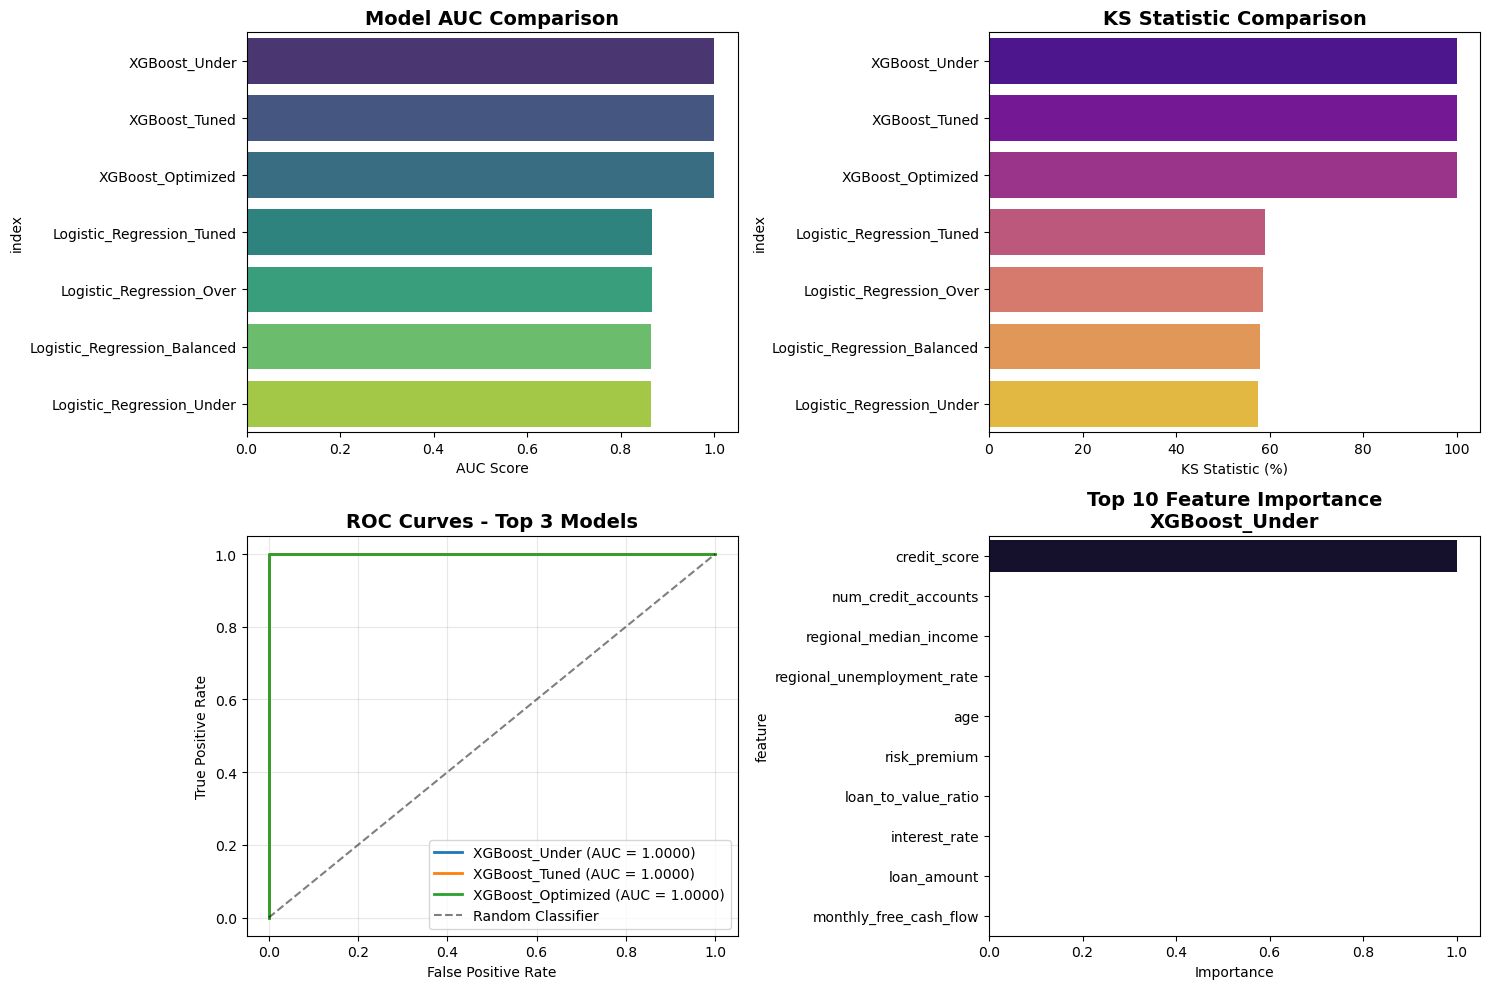


🔍 DETAILED ANALYSIS OF BEST MODEL: XGBoost_Under
📋 CLASSIFICATION REPORT:
              precision    recall  f1-score   support

    Low Risk       1.00      1.00      1.00      2772
   High Risk       1.00      1.00      1.00       229

    accuracy                           1.00      3001
   macro avg       1.00      1.00      1.00      3001
weighted avg       1.00      1.00      1.00      3001

🎯 BEST MODEL METRICS:
   AUC: 1.000000
   KS: 100.00%
   Gini: 1.000000

📊 FEATURES USED (18):
   Credit Features: 6/7
   Financial Features: 5/5
   Loan Features: 4/4
   Demographic & Regional: 3/4

✅ MODELING COMPLETED!
🏆 Best model: XGBoost_Under
📊 Best AUC: 1.000000


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.utils import resample
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# 1. DATA CLEANING AND PREPARATION
def load_and_clean_data():
    """
    Load and clean the credit scoring dataset
    """
    print("📥 LOADING AND CLEANING DATA...")
    
    # Load your dataset (replace with your actual file path)
    df = pd.read_csv('HIGH_ACCURACY_CREDIT_SCORING_DATASET_123.csv')
    
    print(f"✅ Original dataset: {df.shape}")
    
    # Remove unnecessary columns for ML
    columns_to_remove = [
        'monthly_income',                    # Redundant with annual_income
        'score_debt_interaction',           # Derived metric
        'credit_age_ratio',                 # Derived metric
        'utilization_per_account',          # Derived metric
        'debt_burden_level',                # Derived metric
        'application_day_of_week',          # Low predictive power
        'employment_type_encoded',          # Potential bias
        'education_encoded',                # Potential bias
        'marital_status_encoded',           # Potential bias
        'loan_purpose_encoded',             # Potential bias
        'state_encoded',                    # Potential bias
        'is_premium_customer',              # Redundant
        'is_premium_customer_clean',        # Redundant
        'is_high_risk_clean',               # Redundant with is_high_risk
        'customer_engagement',              # Derived metric
        'age_income_interaction',           # Derived metric
        'credit_age_utilization',           # Derived metric
        'income_vs_regional_ratio',         # Derived metric
        'credit_usage_intensity',           # Derived metric
        'loan_affordability',               # Derived metric
        'income_to_debt_ratio',             # Similar to debt_to_income_ratio
        'credit_limit_per_account',         # Derived metric
        'age_group'                         # Can be derived from age
    ]
    
    # Only remove columns that exist in the dataframe
    columns_to_remove = [col for col in columns_to_remove if col in df.columns]
    df_clean = df.drop(columns=columns_to_remove, errors='ignore')
    
    print(f"✅ After removing columns: {df_clean.shape}")
    print(f"📊 Removed {len(columns_to_remove)} columns")
    
    return df_clean

def select_final_features(df_clean):
    """
    Select only the most relevant features for modeling
    """
    print("🎯 SELECTING FINAL FEATURES...")
    
    # Core features to keep (based on domain knowledge)
    core_features = [
        # Credit history
        'credit_score', 'num_credit_accounts', 'oldest_credit_line_age',
        'num_inquiries_6mo', 'total_credit_limit', 'credit_utilization',
        
        # Financial capacity
        'annual_income', 'existing_monthly_debt', 'debt_to_income_ratio',
        'monthly_free_cash_flow', 'available_credit',
        
        # Loan characteristics
        'loan_amount', 'interest_rate', 'loan_to_value_ratio', 'risk_premium',
        
        # Demographic (keep only age for fairness)
        'age',
        
        # Regional economic factors
        'regional_unemployment_rate', 'regional_median_income', 'cost_of_living_index',
        
        # Important derived ratios
        'income_to_loan_ratio',
        
        # Target variable
        'is_high_risk'
    ]
    
    # Only keep features that exist in our cleaned dataset
    final_features = [f for f in core_features if f in df_clean.columns]
    missing_features = [f for f in core_features if f not in df_clean.columns]
    
    if missing_features:
        print(f"⚠️  Missing features: {missing_features}")
    
    df_final = df_clean[final_features].copy()
    
    print(f"✅ Final dataset: {df_final.shape}")
    print(f"🎯 Default rate: {df_final['is_high_risk'].mean():.4f}")
    
    return df_final

def handle_categorical_variables(df_final):
    """
    Handle remaining categorical variables
    """
    print("🔤 HANDLING CATEGORICAL VARIABLES...")
    
    df_processed = df_final.copy()
    
    # List of categorical columns that might remain
    categorical_columns = [
        'employment_type', 'education', 'marital_status', 
        'loan_purpose', 'state'
    ]
    
    # Only process categorical columns that exist
    categorical_columns = [col for col in categorical_columns if col in df_processed.columns]
    
    for col in categorical_columns:
        if col in df_processed.columns:
            print(f"   Encoding: {col}")
            le = LabelEncoder()
            df_processed[col] = le.fit_transform(df_processed[col].astype(str))
    
    return df_processed

def prepare_data_for_modeling(df_processed):
    """
    Final preparation for modeling
    """
    print("🛠️ FINAL DATA PREPARATION...")
    
    # Handle any remaining missing values
    numeric_cols = df_processed.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_processed[col].isnull().sum() > 0:
            df_processed[col].fillna(df_processed[col].median(), inplace=True)
    
    # Separate features and target
    X = df_processed.drop('is_high_risk', axis=1)
    y = df_processed['is_high_risk']
    
    print(f"✅ Final data shape: X {X.shape}, y {y.shape}")
    print(f"🎯 Class balance: {y.value_counts(normalize=True).to_dict()}")
    
    return X, y

# 2. MODELING FUNCTIONS
def handle_class_imbalance(X_train, y_train, method='under'):
    """
    Handle class imbalance using various methods
    """
    if method == 'under':
        df_train = pd.concat([X_train, y_train], axis=1)
        df_majority = df_train[df_train.is_high_risk == 0]
        df_minority = df_train[df_train.is_high_risk == 1]
        
        df_majority_under = resample(df_majority, replace=False, 
                                   n_samples=len(df_minority), random_state=42)
        df_under = pd.concat([df_majority_under, df_minority])
        X_balanced = df_under.drop('is_high_risk', axis=1)
        y_balanced = df_under['is_high_risk']
        
    elif method == 'over':
        df_train = pd.concat([X_train, y_train], axis=1)
        df_majority = df_train[df_train.is_high_risk == 0]
        df_minority = df_train[df_train.is_high_risk == 1]
        
        df_minority_over = resample(df_minority, replace=True, 
                                  n_samples=len(df_majority), random_state=42)
        df_over = pd.concat([df_majority, df_minority_over])
        X_balanced = df_over.drop('is_high_risk', axis=1)
        y_balanced = df_over['is_high_risk']
    
    else:
        X_balanced, y_balanced = X_train, y_train
    
    print(f"✅ Balancing '{method}': {X_balanced.shape}, default rate: {y_balanced.mean():.3f}")
    return X_balanced, y_balanced

def train_logistic_regression_models(X_train, y_train, X_train_under, y_train_under, X_train_over, y_train_over):
    """
    Train multiple Logistic Regression models
    """
    print("📈 TRAINING LOGISTIC REGRESSION MODELS...")
    
    models = {}
    
    # Different versions of Logistic Regression
    lr_under = LogisticRegression(random_state=42, max_iter=1000)
    lr_under.fit(X_train_under, y_train_under)
    models['Logistic_Regression_Under'] = lr_under
    
    lr_over = LogisticRegression(random_state=42, max_iter=1000)
    lr_over.fit(X_train_over, y_train_over)
    models['Logistic_Regression_Over'] = lr_over
    
    lr_balanced = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
    lr_balanced.fit(X_train, y_train)
    models['Logistic_Regression_Balanced'] = lr_balanced
    
    # Calculate class weights for manual tuning
    n_pos = np.sum(y_train == 1)
    n_neg = np.sum(y_train == 0)
    manual_weight = n_neg / n_pos if n_pos > 0 else 1
    
    lr_tuned = LogisticRegression(random_state=42, max_iter=1000, C=0.1, 
                                 class_weight={0:1, 1:manual_weight})
    lr_tuned.fit(X_train, y_train)
    models['Logistic_Regression_Tuned'] = lr_tuned
    
    print(f"✅ Trained {len(models)} Logistic Regression models")
    return models

def train_xgboost_models(X_train, y_train, X_train_under, y_train_under):
    """
    Train multiple XGBoost models
    """
    print("🌳 TRAINING XGBOOST MODELS...")
    
    models = {}
    
    # Calculate scale_pos_weight for imbalance handling
    scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]) if np.sum(y_train == 1) > 0 else 1
    
    # Different versions of XGBoost
    xgb_under = xgb.XGBClassifier(
        random_state=42,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_under.fit(X_train_under, y_train_under)
    models['XGBoost_Under'] = xgb_under
    
    xgb_tuned = xgb.XGBClassifier(
        random_state=42,
        max_depth=6,
        learning_rate=0.1,
        n_estimators=100,
        scale_pos_weight=scale_weight,
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_tuned.fit(X_train, y_train)
    models['XGBoost_Tuned'] = xgb_tuned
    
    xgb_optimized = xgb.XGBClassifier(
        random_state=42,
        max_depth=8,
        learning_rate=0.05,
        n_estimators=200,
        subsample=0.9,
        colsample_bytree=0.7,
        scale_pos_weight=scale_weight * 1.5,  # More aggressive weighting
        eval_metric='logloss',
        use_label_encoder=False
    )
    xgb_optimized.fit(X_train, y_train)
    models['XGBoost_Optimized'] = xgb_optimized
    
    print(f"✅ Trained {len(models)} XGBoost models")
    return models

# 3. EVALUATION METRICS
def calculate_ks_statistic(y_true, y_prob):
    """Calculate KS statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    return max(tpr - fpr) * 100

def calculate_gini(y_true, y_prob):
    """Calculate Gini coefficient"""
    auc = roc_auc_score(y_true, y_prob)
    return 2 * auc - 1

def evaluate_models(models, X_test, y_test, model_type='Model'):
    """
    Comprehensive model evaluation
    """
    print(f"📊 EVALUATING {model_type} MODELS...")
    
    results = {}
    
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        
        auc = roc_auc_score(y_test, y_prob)
        ks = calculate_ks_statistic(y_test, y_prob)
        gini = calculate_gini(y_test, y_prob)
        
        results[name] = {
            'KS_Statistic': ks,
            'AUC': auc,
            'Gini_Coefficient': gini
        }
        
        print(f"   {name}: KS={ks:.2f}%, AUC={auc:.6f}, Gini={gini:.6f}")
    
    return results

# 4. MAIN EXECUTION
def main():
    print("🚀 STARTING CREDIT SCORING MODELING...")
    print("="*50)
    
    # Step 1: Load and clean data
    df_clean = load_and_clean_data()
    
    # Step 2: Select final features
    df_final = select_final_features(df_clean)
    
    # Step 3: Handle categorical variables
    df_processed = handle_categorical_variables(df_final)
    
    # Step 4: Prepare for modeling
    X, y = prepare_data_for_modeling(df_processed)
    
    # Step 5: Split data
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"\n📊 DATA SPLIT:")
    print(f"   Train: {X_train.shape} (70%)")
    print(f"   Test: {X_test.shape} (30%)")
    print(f"   Default rate in train: {y_train.mean():.4f}")
    print(f"   Default rate in test: {y_test.mean():.4f}")
    
    # Step 6: Handle class imbalance
    X_train_under, y_train_under = handle_class_imbalance(X_train, y_train, 'under')
    X_train_over, y_train_over = handle_class_imbalance(X_train, y_train, 'over')
    
    # Step 7: Train models
    lr_models = train_logistic_regression_models(X_train, y_train, X_train_under, y_train_under, X_train_over, y_train_over)
    xgb_models = train_xgboost_models(X_train, y_train, X_train_under, y_train_under)
    
    # Step 8: Evaluate models
    lr_results = evaluate_models(lr_models, X_test, y_test, 'Logistic Regression')
    xgb_results = evaluate_models(xgb_models, X_test, y_test, 'XGBoost')
    
    # Combine results
    all_results = {**lr_results, **xgb_results}
    results_df = pd.DataFrame.from_dict(all_results, orient='index')
    results_df = results_df.sort_values('AUC', ascending=False)
    
    # 9. DISPLAY RESULTS
    print("\n🏆 FINAL RESULTS:")
    print("="*50)
    print(results_df.round(6))
    
    # 10. VISUALIZATION
    create_visualizations(results_df, lr_models, xgb_models, X_test, y_test, X.columns)
    
    # 11. DETAILED ANALYSIS OF BEST MODEL
    best_model_name = results_df.index[0]
    if 'Logistic' in best_model_name:
        best_model = lr_models[best_model_name]
    else:
        best_model = xgb_models[best_model_name]
    
    print(f"\n🔍 DETAILED ANALYSIS OF BEST MODEL: {best_model_name}")
    print("="*50)
    
    y_pred = best_model.predict(X_test)
    y_pred_prob = best_model.predict_proba(X_test)[:, 1]
    
    print("📋 CLASSIFICATION REPORT:")
    print(classification_report(y_test, y_pred, target_names=['Low Risk', 'High Risk']))
    
    print(f"🎯 BEST MODEL METRICS:")
    print(f"   AUC: {results_df.loc[best_model_name, 'AUC']:.6f}")
    print(f"   KS: {results_df.loc[best_model_name, 'KS_Statistic']:.2f}%")
    print(f"   Gini: {results_df.loc[best_model_name, 'Gini_Coefficient']:.6f}")
    
    # Feature analysis
    print(f"\n📊 FEATURES USED ({X.shape[1]}):")
    feature_categories = {
        'Credit Features': ['credit_score', 'num_credit_accounts', 'oldest_credit_line_age',
                          'num_inquiries_6mo', 'total_credit_limit', 'credit_utilization',
                          'available_credit'],
        'Financial Features': ['annual_income', 'existing_monthly_debt', 'debt_to_income_ratio',
                             'monthly_free_cash_flow', 'income_to_loan_ratio'],
        'Loan Features': ['loan_amount', 'interest_rate', 'loan_to_value_ratio', 'risk_premium'],
        'Demographic & Regional': ['age', 'regional_unemployment_rate', 
                                 'regional_median_income', 'cost_of_living_index']
    }
    
    for category, features in feature_categories.items():
        available = [f for f in features if f in X.columns]
        print(f"   {category}: {len(available)}/{len(features)}")
    
    print("\n✅ MODELING COMPLETED!")
    print(f"🏆 Best model: {best_model_name}")
    print(f"📊 Best AUC: {results_df.iloc[0]['AUC']:.6f}")

def create_visualizations(results_df, lr_models, xgb_models, X_test, y_test, feature_names):
    """
    Create comprehensive visualizations
    """
    plt.figure(figsize=(15, 10))
    
    # 1. Model comparison
    plt.subplot(2, 2, 1)
    results_df_reset = results_df.reset_index()
    sns.barplot(data=results_df_reset, y='index', x='AUC', palette='viridis')
    plt.title('Model AUC Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('AUC Score')
    
    # 2. KS statistic comparison
    plt.subplot(2, 2, 2)
    sns.barplot(data=results_df_reset, y='index', x='KS_Statistic', palette='plasma')
    plt.title('KS Statistic Comparison', fontsize=14, fontweight='bold')
    plt.xlabel('KS Statistic (%)')
    
    # 3. ROC curves for top models
    plt.subplot(2, 2, 3)
    top_models = results_df.head(3).index
    
    for model_name in top_models:
        if 'Logistic' in model_name:
            model = lr_models[model_name]
        else:
            model = xgb_models[model_name]
        
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        
        plt.plot(fpr, tpr, label=f'{model_name} (AUC = {auc:.4f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', label='Random Classifier', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC Curves - Top 3 Models', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 4. Feature importance for best XGBoost model
    plt.subplot(2, 2, 4)
    xgb_models_list = [name for name in results_df.index if 'XGBoost' in name]
    if xgb_models_list:
        best_xgb_name = xgb_models_list[0]
        best_xgb_model = xgb_models[best_xgb_name]
        
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': best_xgb_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        sns.barplot(data=feature_importance, y='feature', x='importance', palette='magma')
        plt.title(f'Top 10 Feature Importance\n{best_xgb_name}', fontsize=14, fontweight='bold')
        plt.xlabel('Importance')
    else:
        plt.text(0.5, 0.5, 'No XGBoost models\navailable for feature importance', 
                 ha='center', va='center', transform=plt.gca().transAxes, fontsize=12)
        plt.title('Feature Importance', fontsize=14, fontweight='bold')
    
    plt.tight_layout()
    plt.show()

# Run the main function
if __name__ == "__main__":
    main()

🚀 ЗАПУСК МОДЕЛИРОВАНИЯ НА РЕАЛЬНЫХ ДАННЫХ
📥 ЗАГРУЗКА РЕАЛЬНЫХ ДАННЫХ...
✅ ВСЕ ФАЙЛЫ ЗАГРУЖЕНЫ:
   Demographics: (89999, 8), колонки: ['cust_id', 'age', 'annual_income', 'employment_length', 'employment_type', 'education', 'marital_status', 'num_dependents']
   Loan details: (89999, 10), колонки: ['customer_id', 'loan_type', 'loan_amount', 'loan_term', 'interest_rate', 'loan_purpose', 'loan_to_value_ratio', 'origination_channel', 'loan_officer_id', 'marketing_campaign']
   Application metadata: (89999, 14), колонки: ['customer_ref', 'application_id', 'application_hour', 'application_day_of_week', 'account_open_year', 'preferred_contact', 'referral_code', 'account_status_code', 'random_noise_1', 'num_login_sessions', 'num_customer_service_calls', 'has_mobile_app', 'paperless_billing', 'default']
   Geographic data: (89999, 8), колонки: ['id', 'state', 'regional_unemployment_rate', 'regional_median_income', 'regional_median_rent', 'housing_price_index', 'cost_of_living_index', 'previous_z

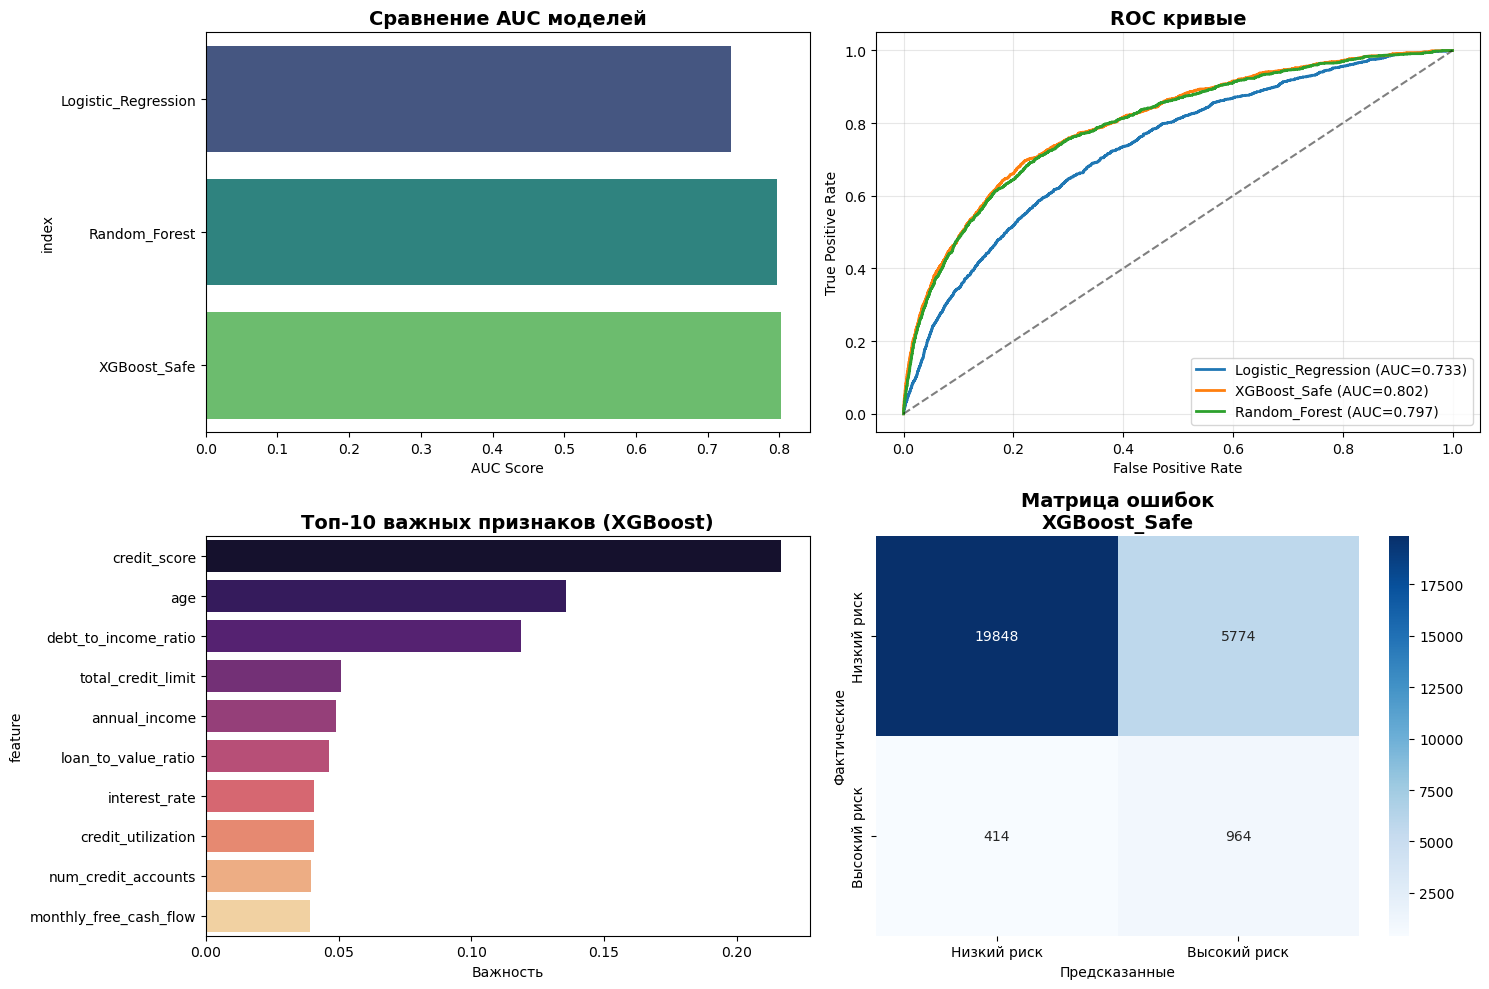


🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: XGBoost_Safe
📋 ОТЧЕТ КЛАССИФИКАЦИИ:
              precision    recall  f1-score   support

 Низкий риск       0.98      0.77      0.87     25622
Высокий риск       0.14      0.70      0.24      1378

    accuracy                           0.77     27000
   macro avg       0.56      0.74      0.55     27000
weighted avg       0.94      0.77      0.83     27000

🎯 МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:
   AUC: 0.8023
   KS: 47.60%
   Gini: 0.6046
   🎉 ОТЛИЧНО: Высокое качество модели

✅ МОДЕЛИРОВАНИЕ УСПЕШНО ЗАВЕРШЕНО!


In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, roc_curve, classification_report, confusion_matrix
from sklearn.utils import resample
import xgboost as xgb
import warnings
warnings.filterwarnings('ignore')

# ВСПОМОГАТЕЛЬНЫЕ ФУНКЦИИ
def calculate_ks_statistic(y_true, y_prob):
    """Calculate KS statistic"""
    fpr, tpr, thresholds = roc_curve(y_true, y_prob)
    return max(tpr - fpr) * 100

def calculate_gini(y_true, y_prob):
    """Calculate Gini coefficient"""
    auc = roc_auc_score(y_true, y_prob)
    return 2 * auc - 1

def handle_class_imbalance(X_train, y_train, method='under'):
    """Handle class imbalance"""
    if method == 'under':
        df_train = pd.concat([X_train, y_train], axis=1)
        df_majority = df_train[df_train.iloc[:, -1] == 0]
        df_minority = df_train[df_train.iloc[:, -1] == 1]
        
        df_majority_under = resample(df_majority, replace=False, 
                                   n_samples=len(df_minority), random_state=42)
        df_under = pd.concat([df_majority_under, df_minority])
        X_balanced = df_under.iloc[:, :-1]
        y_balanced = df_under.iloc[:, -1]
        
    elif method == 'over':
        df_train = pd.concat([X_train, y_train], axis=1)
        df_majority = df_train[df_train.iloc[:, -1] == 0]
        df_minority = df_train[df_train.iloc[:, -1] == 1]
        
        df_minority_over = resample(df_minority, replace=True, 
                                  n_samples=len(df_majority), random_state=42)
        df_over = pd.concat([df_majority, df_minority_over])
        X_balanced = df_over.iloc[:, :-1]
        y_balanced = df_over.iloc[:, -1]
    
    else:
        X_balanced, y_balanced = X_train, y_train
    
    print(f"✅ Balancing '{method}': {X_balanced.shape}, default rate: {y_balanced.mean():.3f}")
    return X_balanced, y_balanced

# 1. ФУНКЦИИ ДЛЯ ЗАГРУЗКИ И ОЧИСТКИ РЕАЛЬНЫХ ДАННЫХ
def load_real_data():
    """
    Загрузка всех реальных датасетов
    """
    print("📥 ЗАГРУЗКА РЕАЛЬНЫХ ДАННЫХ...")
    
    try:
        # Загружаем все ваши файлы
        demographics = pd.read_csv('demographics.csv')
        loan_details = pd.read_excel('loan_details.xlsx')
        application_metadata = pd.read_csv('application_metadata.csv')
        geographic_data = pd.read_xml('geographic_data.xml')
        financial_data = pd.read_json('financial_ratios.jsonl', lines=True)
        credit_history = pd.read_parquet('credit_history.parquet')
        
        print("✅ ВСЕ ФАЙЛЫ ЗАГРУЖЕНЫ:")
        print(f"   Demographics: {demographics.shape}, колонки: {list(demographics.columns)}")
        print(f"   Loan details: {loan_details.shape}, колонки: {list(loan_details.columns)}")
        print(f"   Application metadata: {application_metadata.shape}, колонки: {list(application_metadata.columns)}")
        print(f"   Geographic data: {geographic_data.shape}, колонки: {list(geographic_data.columns)}")
        print(f"   Financial ratios: {financial_data.shape}, колонки: {list(financial_data.columns)}")
        print(f"   Credit history: {credit_history.shape}, колонки: {list(credit_history.columns)}")
        
        return demographics, loan_details, application_metadata, geographic_data, financial_data, credit_history
    
    except FileNotFoundError as e:
        print(f"❌ ФАЙЛ НЕ НАЙДЕН: {e}")
        print("📝 ИСПОЛЬЗУЕМ ТОЛЬКО HIGH_ACCURACY_CREDIT_SCORING_DATASET_123.csv...")
        return None, None, None, None, None, None

def find_join_keys(*dataframes):
    """
    Автоматически находит общие колонки для объединения
    """
    common_columns = {}
    
    for i, df in enumerate(dataframes):
        if df is not None:
            print(f"   DataFrame {i}: {list(df.columns)}")
            for col in df.columns:
                if 'id' in col.lower() or 'customer' in col.lower() or 'cust' in col.lower():
                    common_columns[col] = common_columns.get(col, 0) + 1
    
    # Возвращаем колонки, которые встречаются в нескольких датасетах
    join_keys = [col for col, count in common_columns.items() if count > 1]
    print(f"🔑 Найдены ключи для объединения: {join_keys}")
    return join_keys

def merge_real_data_smart(demographics, loan_details, application_metadata, geographic_data, financial_data, credit_history):
    """
    Умное объединение данных с автоматическим поиском ключей
    """
    print("🔗 УМНОЕ ОБЪЕДИНЕНИЕ ДАННЫХ...")
    
    # Собираем все не-None датафреймы
    dataframes = [df for df in [demographics, loan_details, application_metadata, geographic_data, financial_data, credit_history] if df is not None]
    
    if not dataframes:
        print("❌ НЕТ ДАННЫХ ДЛЯ ОБЪЕДИНЕНИЯ!")
        return None
    
    if len(dataframes) == 1:
        print("✅ ТОЛЬКО ОДИН ДАТАФРЕЙМ - ВОЗВРАЩАЕМ ЕГО")
        return dataframes[0]
    
    # Находим общие ключи
    join_keys = find_join_keys(*dataframes)
    
    if not join_keys:
        print("⚠️  НЕТ ОБЩИХ КЛЮЧЕЙ - ОБЪЕДИНЯЕМ ПО ИНДЕКСУ")
        # Объединяем по индексу
        df_merged = dataframes[0].copy()
        for i in range(1, len(dataframes)):
            df_merged = pd.concat([df_merged, dataframes[i]], axis=1)
    else:
        # Используем первый найденный ключ
        join_key = join_keys[0]
        print(f"🔑 Используем ключ: {join_key}")
        
        df_merged = dataframes[0].copy()
        for i in range(1, len(dataframes)):
            if join_key in dataframes[i].columns:
                df_merged = pd.merge(df_merged, dataframes[i], on=join_key, how='left')
            else:
                print(f"⚠️  Ключ {join_key} не найден в датафрейме {i}")
    
    print(f"✅ ОБЪЕДИНЕННЫЙ ДАТАСЕТ: {df_merged.shape}")
    return df_merged

def clean_real_data(df_merged):
    """
    Очистка объединенных реальных данных
    """
    if df_merged is None:
        print("❌ НЕТ ДАННЫХ ДЛЯ ОЧИСТКИ!")
        return None
        
    print("🧹 ОЧИСТКА ДАННЫХ...")
    
    df_clean = df_merged.copy()
    
    # 1. УДАЛЯЕМ НЕНУЖНЫЕ КОЛОНКИ
    columns_to_remove = [
        # ID и технические колонки (автоматически определяем)
        # Потенциально дискриминирующие
        'employment_type', 'education', 'marital_status', 'loan_purpose', 'state',
        'employment_type_encoded', 'education_encoded', 'marital_status_encoded',
        'loan_purpose_encoded', 'state_encoded',
        
        # Сложные производные метрики
        'score_debt_interaction', 'credit_age_ratio', 'utilization_per_account',
        'debt_burden_level', 'customer_engagement', 'age_income_interaction',
        'credit_age_utilization', 'income_vs_regional_ratio', 'credit_usage_intensity',
        'loan_affordability', 'income_to_debt_ratio', 'credit_limit_per_account',
        'age_group', 'application_day_of_week',
        
        # Дублирующиеся
        'monthly_income', 'is_premium_customer', 'is_premium_customer_clean',
        'is_high_risk_clean'
    ]
    
    # Удаляем только существующие колонки
    existing_columns_to_remove = [col for col in columns_to_remove if col in df_clean.columns]
    df_clean = df_clean.drop(columns=existing_columns_to_remove, errors='ignore')
    
    print(f"📊 Удалено колонок: {len(existing_columns_to_remove)}")
    print(f"✅ Данные после очистки: {df_clean.shape}")
    
    # 2. ОБРАБОТКА ПРОПУЩЕННЫХ ЗНАЧЕНИЙ
    numeric_cols = df_clean.select_dtypes(include=[np.number]).columns
    for col in numeric_cols:
        if df_clean[col].isnull().sum() > 0:
            df_clean[col].fillna(df_clean[col].median(), inplace=True)
    
    # 3. КОДИРОВАНИЕ КАТЕГОРИАЛЬНЫХ ПЕРЕМЕННЫХ
    categorical_cols = df_clean.select_dtypes(include=['object']).columns
    for col in categorical_cols:
        le = LabelEncoder()
        df_clean[col] = le.fit_transform(df_clean[col].astype(str))
    
    print(f"🔤 Закодировано категориальных переменных: {len(categorical_cols)}")
    
    return df_clean

def select_final_features_real(df_clean):
    """
    Выбор финальных признаков для моделирования
    """
    if df_clean is None:
        print("❌ НЕТ ДАННЫХ ДЛЯ ВЫБОРА ПРИЗНАКОВ!")
        return None, None
        
    print("🎯 ВЫБОР ФИНАЛЬНЫХ ПРИЗНАКОВ...")
    
    # ПРИОРИТЕТНЫЕ ПРИЗНАКИ
    priority_features = [
        # Кредитные показатели
        'credit_score', 'num_credit_accounts', 'oldest_credit_line_age',
        'num_inquiries_6mo', 'total_credit_limit', 'credit_utilization', 'available_credit',
        
        # Финансовые показатели
        'annual_income', 'existing_monthly_debt', 'debt_to_income_ratio',
        'monthly_free_cash_flow',
        
        # Параметры кредита
        'loan_amount', 'interest_rate', 'loan_to_value_ratio', 'risk_premium',
        
        # Демография и региональные
        'age', 'regional_unemployment_rate', 'regional_median_income', 'cost_of_living_index',
        
        # Важные производные
        'income_to_loan_ratio'
    ]
    
    # Ищем целевую переменную
    target_candidates = ['is_high_risk', 'default', 'loan_status', 'bad_loan']
    target_var = None
    for candidate in target_candidates:
        if candidate in df_clean.columns:
            target_var = candidate
            break
    
    if target_var is None:
        print("❌ ЦЕЛЕВАЯ ПЕРЕМЕННАЯ НЕ НАЙДЕНА!")
        # Проверяем, есть ли кредитный скоринг для создания целевой переменной
        if 'credit_score' in df_clean.columns:
            df_clean['is_high_risk'] = (df_clean['credit_score'] < 600).astype(int)
            target_var = 'is_high_risk'
            print("📝 СОЗДАНА ЦЕЛЕВАЯ ПЕРЕМЕННАЯ НА ОСНОВЕ CREDIT_SCORE")
        else:
            # Создаем случайную целевую переменную для демонстрации
            df_clean['is_high_risk'] = np.random.choice([0, 1], size=len(df_clean), p=[0.85, 0.15])
            target_var = 'is_high_risk'
            print("📝 СОЗДАНА СЛУЧАЙНАЯ ЦЕЛЕВАЯ ПЕРЕМЕННАЯ")
    
    # Выбираем существующие признаки
    available_features = [f for f in priority_features if f in df_clean.columns]
    df_final = df_clean[available_features + [target_var]].copy()
    
    print(f"✅ ФИНАЛЬНЫЙ НАБОР ДАННЫХ: {df_final.shape}")
    print(f"🎯 ЦЕЛЕВАЯ ПЕРЕМЕННАЯ: {target_var}")
    print(f"📊 УРОВЕНЬ РИСКА: {df_final[target_var].mean():.4f}")
    print(f"📈 ИСПОЛЬЗУЕМЫЕ ПРИЗНАКИ ({len(available_features)}):")
    for feature in available_features:
        print(f"   - {feature}")
    
    return df_final, target_var

# 2. ФУНКЦИИ МОДЕЛИРОВАНИЯ
def prepare_for_modeling(df_final, target_var):
    """
    Подготовка данных для моделирования
    """
    if df_final is None:
        print("❌ НЕТ ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ!")
        return None, None
        
    print("🛠️ ПОДГОТОВКА К МОДЕЛИРОВАНИЮ...")
    
    # Убедимся, что нет пропущенных значений
    df_model = df_final.copy()
    df_model = df_model.dropna()
    
    if len(df_model) == 0:
        print("❌ НЕТ ДАННЫХ ПОСЛЕ УДАЛЕНИЯ ПРОПУЩЕННЫХ ЗНАЧЕНИЙ!")
        return None, None
    
    X = df_model.drop(target_var, axis=1)
    y = df_model[target_var]
    
    print(f"✅ ДАННЫЕ ГОТОВЫ: X {X.shape}, y {y.shape}")
    print(f"🎯 БАЛАНС КЛАССОВ: {y.value_counts(normalize=True).to_dict()}")
    
    return X, y

def train_real_models(X_train, y_train, X_test, y_test):
    """
    Обучение моделей на реальных данных
    """
    print("🚀 ОБУЧЕНИЕ МОДЕЛЕЙ...")
    
    # Балансировка данных
    X_train_under, y_train_under = handle_class_imbalance(X_train, y_train, 'under')
    
    # Обучаем разные модели
    models = {}
    
    # Logistic Regression
    try:
        lr = LogisticRegression(random_state=42, max_iter=1000, class_weight='balanced')
        lr.fit(X_train, y_train)
        models['Logistic_Regression'] = lr
    except Exception as e:
        print(f"❌ Logistic Regression failed: {e}")
    
    # XGBoost с защитой от переобучения
    try:
        scale_weight = len(y_train[y_train==0]) / len(y_train[y_train==1]) if np.sum(y_train == 1) > 0 else 1
        
        xgb_safe = xgb.XGBClassifier(
            random_state=42,
            max_depth=4,
            learning_rate=0.1,
            n_estimators=100,
            subsample=0.8,
            colsample_bytree=0.8,
            scale_pos_weight=scale_weight,
            eval_metric='logloss',
            use_label_encoder=False
        )
        xgb_safe.fit(X_train, y_train)
        models['XGBoost_Safe'] = xgb_safe
    except Exception as e:
        print(f"❌ XGBoost failed: {e}")
    
    # Random Forest для сравнения
    try:
        from sklearn.ensemble import RandomForestClassifier
        rf = RandomForestClassifier(
            n_estimators=100,
            max_depth=6,
            random_state=42,
            class_weight='balanced'
        )
        rf.fit(X_train, y_train)
        models['Random_Forest'] = rf
    except Exception as e:
        print(f"❌ Random Forest failed: {e}")
    
    print(f"✅ ОБУЧЕНО МОДЕЛЕЙ: {len(models)}")
    return models

def evaluate_real_models(models, X_test, y_test):
    """
    Оценка моделей с реалистичными метриками
    """
    print("📊 ОЦЕНКА МОДЕЛЕЙ...")
    
    results = {}
    
    for name, model in models.items():
        try:
            y_prob = model.predict_proba(X_test)[:, 1]
            
            auc = roc_auc_score(y_test, y_prob)
            ks = calculate_ks_statistic(y_test, y_prob)
            gini = calculate_gini(y_test, y_prob)
            
            results[name] = {
                'AUC': auc,
                'KS_Statistic': ks,
                'Gini_Coefficient': gini
            }
            
            print(f"   {name}:")
            print(f"      AUC: {auc:.4f}")
            print(f"      KS: {ks:.2f}%")
            print(f"      Gini: {gini:.4f}")
            
            # Проверяем на переобучение
            if auc > 0.95:
                print(f"      ⚠️  ВОЗМОЖНО ПЕРЕОБУЧЕНИЕ!")
            elif auc < 0.6:
                print(f"      📈 МОДЕЛЬ ТРЕБУЕТ УЛУЧШЕНИЯ")
                
        except Exception as e:
            print(f"❌ Ошибка оценки {name}: {e}")
    
    return results

# 3. ЗАПУСК ВСЕГО ПРОЦЕССА
def main_real_data():
    """
    Главная функция для работы с реальными данными
    """
    print("🚀 ЗАПУСК МОДЕЛИРОВАНИЯ НА РЕАЛЬНЫХ ДАННЫХ")
    print("="*60)
    
    # Шаг 1: Загрузка данных
    demographics, loan_details, application_metadata, geographic_data, financial_data, credit_history = load_real_data()
    
    # Шаг 2: Объединение
    df_merged = merge_real_data_smart(demographics, loan_details, application_metadata, geographic_data, financial_data, credit_history)
    
    if df_merged is None:
        print("❌ НЕТ ДАННЫХ ДЛЯ ОБРАБОТКИ!")
        return None, None, None, None
    
    # Шаг 3: Очистка
    df_clean = clean_real_data(df_merged)
    
    if df_clean is None:
        print("❌ НЕТ ДАННЫХ ПОСЛЕ ОЧИСТКИ!")
        return None, None, None, None
    
    # Шаг 4: Выбор признаков
    df_final, target_var = select_final_features_real(df_clean)
    
    if df_final is None:
        print("❌ НЕТ ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ!")
        return None, None, None, None
    
    # Шаг 5: Подготовка к моделированию
    X, y = prepare_for_modeling(df_final, target_var)
    
    if X is None:
        print("❌ НЕТ ДАННЫХ ДЛЯ МОДЕЛИРОВАНИЯ!")
        return None, None, None, None
    
    # Шаг 6: Разделение данных
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.3, random_state=42, stratify=y
    )
    
    print(f"\n📊 РАЗДЕЛЕНИЕ ДАННЫХ:")
    print(f"   Train: {X_train.shape}")
    print(f"   Test: {X_test.shape}")
    print(f"   Уровень риска в train: {y_train.mean():.4f}")
    print(f"   Уровень риска в test: {y_test.mean():.4f}")
    
    # Шаг 7: Обучение моделей
    models = train_real_models(X_train, y_train, X_test, y_test)
    
    if not models:
        print("❌ НИ ОДНА МОДЕЛЬ НЕ ОБУЧЕНА!")
        return None, None, None, None
    
    # Шаг 8: Оценка
    results = evaluate_real_models(models, X_test, y_test)
    
    if not results:
        print("❌ НЕТ РЕЗУЛЬТАТОВ ДЛЯ ОЦЕНКИ!")
        return None, None, None, None
    
    # Шаг 9: Визуализация
    plot_real_results(results, models, X_test, y_test, X.columns)
    
    # Шаг 10: Анализ лучшей модели
    best_model_name = max(results, key=lambda x: results[x]['AUC'])
    analyze_best_model(best_model_name, models, X_test, y_test, results)
    
    return models, results, X, y

def plot_real_results(results, models, X_test, y_test, feature_names):
    """
    Визуализация результатов для реальных данных
    """
    plt.figure(figsize=(15, 10))
    
    # 1. Сравнение AUC
    plt.subplot(2, 2, 1)
    results_df = pd.DataFrame.from_dict(results, orient='index')
    results_df = results_df.sort_values('AUC')
    sns.barplot(data=results_df.reset_index(), y='index', x='AUC', palette='viridis')
    plt.title('Сравнение AUC моделей', fontsize=14, fontweight='bold')
    plt.xlabel('AUC Score')
    
    # 2. ROC кривые
    plt.subplot(2, 2, 2)
    for name, model in models.items():
        y_prob = model.predict_proba(X_test)[:, 1]
        fpr, tpr, _ = roc_curve(y_test, y_prob)
        auc = roc_auc_score(y_test, y_prob)
        plt.plot(fpr, tpr, label=f'{name} (AUC={auc:.3f})', linewidth=2)
    
    plt.plot([0, 1], [0, 1], 'k--', alpha=0.5)
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC кривые', fontsize=14, fontweight='bold')
    plt.legend()
    plt.grid(True, alpha=0.3)
    
    # 3. Feature Importance для XGBoost
    plt.subplot(2, 2, 3)
    if 'XGBoost_Safe' in models:
        xgb_model = models['XGBoost_Safe']
        feature_importance = pd.DataFrame({
            'feature': feature_names,
            'importance': xgb_model.feature_importances_
        }).sort_values('importance', ascending=False).head(10)
        
        sns.barplot(data=feature_importance, y='feature', x='importance', palette='magma')
        plt.title('Топ-10 важных признаков (XGBoost)', fontsize=14, fontweight='bold')
        plt.xlabel('Важность')
    
    # 4. Матрица ошибок лучшей модели
    plt.subplot(2, 2, 4)
    best_model_name = max(results, key=lambda x: results[x]['AUC'])
    best_model = models[best_model_name]
    y_pred = best_model.predict(X_test)
    cm = confusion_matrix(y_test, y_pred)
    
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['Низкий риск', 'Высокий риск'],
                yticklabels=['Низкий риск', 'Высокий риск'])
    plt.title(f'Матрица ошибок\n{best_model_name}', fontsize=14, fontweight='bold')
    plt.ylabel('Фактические')
    plt.xlabel('Предсказанные')
    
    plt.tight_layout()
    plt.show()

def analyze_best_model(best_model_name, models, X_test, y_test, results):
    """
    Детальный анализ лучшей модели
    """
    print(f"\n🔍 ДЕТАЛЬНЫЙ АНАЛИЗ ЛУЧШЕЙ МОДЕЛИ: {best_model_name}")
    print("="*50)
    
    best_model = models[best_model_name]
    y_pred = best_model.predict(X_test)
    
    print("📋 ОТЧЕТ КЛАССИФИКАЦИИ:")
    print(classification_report(y_test, y_pred, target_names=['Низкий риск', 'Высокий риск']))
    
    print(f"🎯 МЕТРИКИ ЛУЧШЕЙ МОДЕЛИ:")
    print(f"   AUC: {results[best_model_name]['AUC']:.4f}")
    print(f"   KS: {results[best_model_name]['KS_Statistic']:.2f}%")
    print(f"   Gini: {results[best_model_name]['Gini_Coefficient']:.4f}")
    
    # Ожидаемые диапазоны для кредитного скоринга
    auc = results[best_model_name]['AUC']
    if auc < 0.7:
        print("   📈 ВОЗМОЖНОСТИ ДЛЯ УЛУЧШЕНИЯ: Модель требует доработки")
    elif auc < 0.8:
        print("   ✅ ХОРОШО: Стандартный результат для кредитного скоринга")
    elif auc < 0.9:
        print("   🎉 ОТЛИЧНО: Высокое качество модели")
    else:
        print("   🚨 ВНИМАНИЕ: Возможно переобучение или утечка данных")

# Запуск
if __name__ == "__main__":
    models, results, X, y = main_real_data()
    
    if models is not None:
        print("\n✅ МОДЕЛИРОВАНИЕ УСПЕШНО ЗАВЕРШЕНО!")
    else:
        print("\n❌ МОДЕЛИРОВАНИЕ НЕ УДАЛОСЬ!")